## 1. Loss functions, gradients and step-sizes

In this notebook, we will mainly practice using gradient descent and stochastic gradient descent to solve machine learning problems.

The problems that we are interested in are 

##### Linear regression
$$\min_{\bf w} f(\mathbf{w})= \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \left( \mathbf{x}_i^\top \mathbf{w} - y_i \right)^2$$

##### Ridge regression: 
$$ \min_{\bf w} f(\mathbf{w})= \frac{1}{n} \sum_{i=1}^n \frac{1}{2} \left( \mathbf{x}_i^\top \mathbf{w} - y_i \right)^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2$$




Note that both of the above problems can be writen as an optimization problem of the form: 
$$
\frac 1n \sum_{i=1}^n f_i(\mathbf{w})
$$

where for linear regression: 
$$
f_i(\mathbf{w}) = \frac{1}{2} \left( \mathbf{x}_i^\top \mathbf{w} - y_i \right)^2
$$
and for ridge regression: 
$$
f_i(\mathbf{w}) = \frac{1}{2} \left( \mathbf{x}_i^\top \mathbf{w} - y_i \right)^2 + \frac{\lambda}{2} \|\mathbf{w}\|^2
$$

## Vectorizing your code (optional)
When possible, I will always recommend to rewrite the objective function into matrix form. Using matrix operations instead of explicit sums in implementing machine learning algorithms offers several significant advantages, primarily in terms of computational efficiency, simplicity, and scalability:

1. **Computational Efficiency**: Matrix operations can be highly optimized by modern CPUs and GPUs, taking advantage of vectorized operations and parallel processing. This means that operations can be carried out on multiple data points simultaneously, drastically reducing the time required for computations. This efficiency is particularly crucial for large-scale machine learning tasks, where the datasets and models are enormous. Also, libraries like NumPy are finely tuned and highly optimized for matrix operations.

2. **Simplicity**: Using matrix formulations makes your code closely match their math formulation. You can write more readable code. 

3. **Scalability**: Matrix operations allow for more scalable and flexible algorithm implementations. As data sizes and model complexity grow, the ability to efficiently handle these computations through matrix operations becomes increasingly important. It also makes it easier to adjust and extend algorithms to accommodate new requirements or optimizations.

Our objective functions and gradients can be rewritten as follows:

##### Linear regression
$$f(\mathbf{w})=\frac{1}{2n}\|\mathbf{Xw}-\mathbf{y}\|^2$$

$$\nabla f(\mathbf{w})=\frac{1}{n}\mathbf{X}^\top (\mathbf{Xw}-\mathbf{y})$$

and the closed-form solution is
$$\hat{\mathbf{w}}=(\mathbf{X^\top X})^{-1}\mathbf{X}^\top y$$
##### Ridge regression
$$f(\mathbf{w})=\frac{1}{2n}\|\mathbf{Xw}-\mathbf{y}\|^2+\frac{\lambda}{2}\|\mathbf{w}\|^2$$
$$\nabla f(\mathbf{w})=\frac{1}{n}\mathbf{X}^\top (\mathbf{Xw}-\mathbf{y})+\lambda\mathbf{w}$$

and the closed-form solution is
$$\hat{\mathbf{w}}=(\mathbf{X^\top X}+n\lambda I)^{-1}\mathbf{X}^\top y$$

##  2. Problem setup

First let us import the following standard packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


For both problems, ridge regression and linear regression, $\mathbf{X} \in \mathbb{R}^{n \times d}, y \in \mathbb{R}^n$ are the given data and $\lambda > 0$ is the regularization parameter. 
We generated synthetic data by sampling the rows of matrix $\mathbf{X}$ ($\mathbf{X}[i, :]$) and $\mathbf{y}$ from the standard Gaussian distribution $\mathcal{N}(0, 1)$. We use $n=1000, d=400$. 



## 3. Gradient descent vs Stochastic gradient descent
Recall in class we talked about the update rule of GD and SGD respectively. For GD, we will need to compute the full gradient, that is the gradient using all available data samples.
$$\mathbf{w}^{t+1}=\mathbf{w}^t-\gamma*\nabla f(\mathbf{w^t})$$

While for SGD, we need first to sample one data sample, then compute its gradient.
$$\mathbf{w}^{t+1}=\mathbf{w}^t-\gamma*\nabla f_i(\mathbf{w^t})$$
We will only consider uniform sampling in this experiment.

## 4. Get started
Let's first define our loss functions and their gradients

In [2]:
# define objective function f of linear regression
def f_lin(w, X, y):
    n = X.shape[0]
    return 0.5 * np.linalg.norm(X @ w - y) ** 2 / n

# define fi's
def fi_lin(w, xi, yi):
    return 0.5 * (xi @ w - yi) ** 2

# define gradient of f_lin
def grad_f_lin(w, X, y):
    n = X.shape[0]
    return X.T @ (X @ w - y) / n

# define gradient of fi_lin
def grad_fi_lin(w, xi, yi):
    return xi * (xi @ w - yi)


def f_rig(w, X, y, lamda):
    n = X.shape[0]
    return 0.5 * np.linalg.norm(X @ w - y) ** 2 / n + 0.5 * lamda * np.linalg.norm(w) ** 2

def fi_rig(w, xi, yi, lamda):
    return 0.5 * (xi @ w - yi) ** 2 + 0.5 * lamda * np.linalg.norm(w) ** 2

def grad_f_rig(w, X, y, lamda):
    n = X.shape[0]
    return X.T @ (X @ w - y) / n +lamda * w

def grad_fi_rig(w, xi, yi, lamda):
    return xi * (xi @ w - yi) + lamda * w

Compute the closed-form solutions

In [3]:
def get_solution(X, y, lamda=None):
    if lamda is None:
        return np.linalg.inv(X.T @ X) @ X.T @ y
    else:
        n = X.shape[0]
        I = np.eye(n)
        return np.linalg.inv(X.T @ X + n * lamda * I) @ X.T @ y

Implement gradient descent

In [4]:
def GD(w0, X, y, grad, lr=0.01, max_iter=1000, lamda=None):
    d = w0.shape[0]
    w_arr = np.zeros((max_iter, d))
    w_arr[0] = w0
    
    for j in range(max_iter-1):        
        if lamda is None:
            g = grad(w_arr[j], X, y)

        else:
            g = grad(w_arr[j], X, y, lamda)
        w_arr[j+1] = w_arr[j] - lr * g
        
    return w_arr
    

Another way to write gradient descent

In [5]:
def GD2(w0, X, y, grad, lr=0.01, eps=1e-3, lamda=None):
    w_arr = [w0]
    w = w0
    
    while(True):
        if lamda is None:
            g = grad(w, X, y)
        else:
            g = grad(w, X, y, lamda)
        new_w = w - lr * g
        if np.linalg.norm(new_w-w) < eps:
            break
        else:
            w_arr.append(new_w)
            w = new_w
    return w_arr

Implement gradient descent

In [6]:
def SGD(w0, X, y, grad, lr=0.001, max_iter=10000, lamda=None):
    d = w0.shape[0]
    w_arr = np.zeros((max_iter, d))
    w_arr[0] = w0
    
    for j in range(max_iter-1):
        i = np.random.randint(0, X.shape[0]) # sample a random index
        xi, yi = X[i, :], y[i]
        if lamda is None:
            g = grad(w_arr[j], xi, yi)
        else:
            g = grad(w_arr[j], xi, yi, lamda)
        w_arr[j+1] = w_arr[j] - lr * g
    return w_arr

Get the loss values

In [7]:
def get_loss(w_arr, X, y, f, lamda=None):
    losses = []
    for i,v in enumerate(w_arr):
        if lamda is None:
            loss = f(v, X, y)
        else:
            loss = f(v, X, y, lamda)
        losses.append(loss)
        
    return(losses)
    

### 4.1 Generate data

In [8]:
# generate synthetic data for ridge regression
n, d = 1000, 400
w0 = np.random.randn(d)
X = np.random.randn(n, d)
y = np.random.randn(n)
lam = 0.001

### 4.2 Run experiments
Let's first compare our 2 GD's

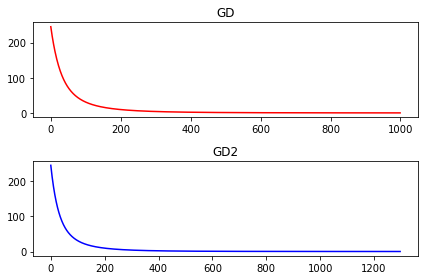

In [9]:
w_arr = GD(w0, X, y, grad_f_lin)
w_arr2 = GD2(w0, X, y, grad_f_lin)
l1 = get_loss(w_arr, X, y, f_lin)
l2 = get_loss(w_arr2, X, y, f_lin)
plt.subplot(2, 1, 1)  
plt.plot(l1, 'r-')
plt.title('GD')

# Second subplot
plt.subplot(2, 1, 2)  
plt.plot(l2, 'b-')
plt.title('GD2')
plt.tight_layout()
 
plt.show()

Compare GD and SGD to solve ridge regression

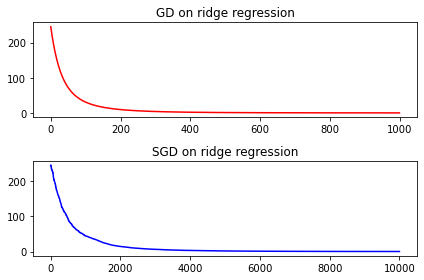

In [10]:
w_gd = GD(w0, X, y, grad_f_rig, lamda=lam)
w_sgd = SGD(w0, X, y, grad_fi_rig, lamda=lam)
l_gd = get_loss(w_gd, X, y, f_rig, lamda=lam)
l_sgd = get_loss(w_sgd, X, y, f_rig, lamda=lam)
plt.subplot(2, 1, 1)  
plt.plot(l_gd, 'r-')
plt.title('GD on ridge regression')

# Second subplot
plt.subplot(2, 1, 2)  
plt.plot(l_sgd, 'b-')
plt.title('SGD on ridge regression')
plt.tight_layout()

plt.show()

### 4.3 The role of step size

To evaluate the convergence rate of SGD we use the relative error measure  $\frac{\|x^k - x^* \|^2}{\|x^0 - x^* \|^2}$ and plot its value as the algorithm progress.  

In [11]:
def convergence(x0, xmin, x_arr):
    relative_error = np.zeros(len(x_arr))
    denominator = np.linalg.norm(x0-xmin) ** 2
    for i,v in enumerate(relative_error):
        relative_error[i] = np.linalg.norm(x_arr[i] - xmin) ** 2 / denominator
    return relative_error

In [12]:
w_min_rig = np.linalg.inv(X.T @ X + n * lam * np.eye(d)) @ X.T @ y

In [13]:
w1 = SGD(w0, X, y, grad_fi_rig, lr = 1e-3, lamda=lam)
w2 = SGD(w0, X, y, grad_fi_rig, lr = 1e-5, lamda=lam)
w3 = SGD(w0, X, y, grad_fi_rig, lr = 1e-7, lamda=lam)

In [14]:
err1 = convergence(w0, w_min_rig, w1)
err2 = convergence(w0, w_min_rig, w2)
err3 = convergence(w0, w_min_rig, w3)


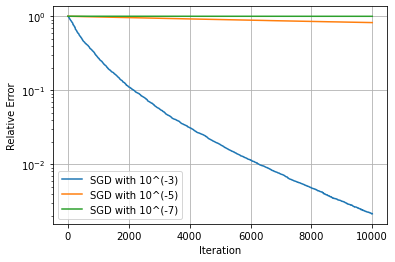

In [15]:
plt.plot(np.arange(len(err1)), err1, label = 'SGD with 10^(-3)')
plt.plot(np.arange(len(err3)), err2, label = 'SGD with 10^(-5)')
plt.plot(np.arange(len(err3)), err3, label = 'SGD with 10^(-7)')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")

plt.legend()

What if the stepsize is too large?

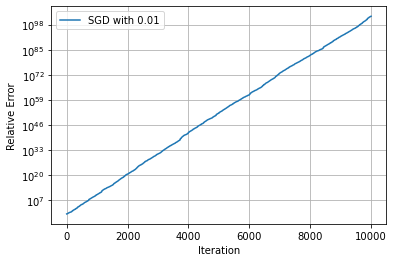

In [16]:
w_large = SGD(w0, X, y, grad_fi_rig, lr = 1e-2, lamda=lam)
err_large = convergence(w0, w_min_rig, w_large)
plt.plot(np.arange(len(err_large)), err_large, label = 'SGD with 0.01')



plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error")
plt.xlabel("Iteration")

plt.legend()

### 4.4 The role of regularization parameter

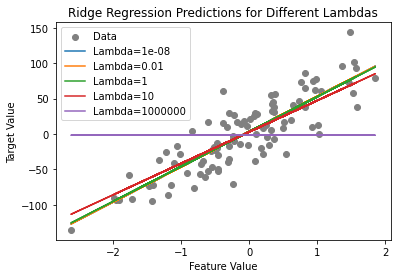

In [17]:
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

X_, y_ = make_regression(n_samples=100, n_features=1, noise=30.0, random_state=42)
lambdas = [1e-8, 1e-2, 1, 10, 1000000]


plt.scatter(X_, y_, color='gray', label='Data')

for lam in lambdas:
    ridge = Ridge(alpha=lam)
    ridge.fit(X_, y_)

    y_pred = ridge.predict(X_)
    plt.plot(X_, y_pred, label=f'Lambda={lam}')

plt.xlabel('Feature Value')
plt.ylabel('Target Value')
plt.title('Ridge Regression Predictions for Different Lambdas')
plt.legend()
plt.show()


In [18]:
ridge.coef_

array([0.00406834])